#**0. CutPaste**

In [ ]:
!pip show tensorflow

Name: tensorflow
Version: 2.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tf_keras


In [ ]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.6 MB/s eta 0:00:00


In [ ]:
!pip install Pillow

# **1. Hardware: check that the GPU is selected correctly**

---




In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri May 10 13:28:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              22W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


#**2. library import**

In [ ]:
from google.colab import files
import os
import numpy as np
import random
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import layers, Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from keras.applications import ResNet50, ResNet101, ResNet152, EfficientNetB4
from keras.callbacks import EarlyStopping

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam, SGD
from keras.optimizers.schedules import ExponentialDecay
from keras.regularizers import l2
from keras.models import load_model

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
import seaborn as sns

from torchvision.models import resnet18, ResNet18_Weights

import datetime
from pathlib import Path

#**3. Login to google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

#**4. Training parameters and pre-trained model selection**

Choix des bloques par learning transfert :
  - Resnet50 : conv5_block1_1_relu, conv4_block1_1_relu, conv3_block1_1_relu, ...

##**4.1 Access path**

In [ ]:
bases_path = "/content/drive/MyDrive/francesco/CutPaste/bases/MVTec/"
models_path = "/content/drive/MyDrive/francesco/CutPaste/" + "models/"

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/francesco/CutPaste')

from imageAugmented import CutPastePatch,ScarPatch, CutOutPatch, rotate_image_randomly
from gaussianDensity import GaussianDensitySklearn

##**4.2 Type of MVTec data set to be driven**


In [ ]:
all_types = ['bottle',
             'cable',
             'capsule',
             'carpet',
             'grid',
             'hazelnut',
             'leather',
             'metal_nut',
             'pill',
             'screw',
             'tile',
             'toothbrush',
             'transistor',
             'wood',
             'zipper']
type = 'wood' # @param ["all", "wood", "screw", "bottle", "cable", "capsule", "grid", "hazelnut", "metal_nut', "pill", "toothbrush", "transistor", "zipper", "wood,screw", "bootle,cable,screw,wood"]

##**4.3 Training parameters**

In [ ]:
nb_classes = 2 # @param [2,3] {type:"raw"}

batch_size = 16  # @param [1,2,4,8,16,24, 32,64,128, 256] {type:"raw"}

epochs = 100  # @param [5, 10,20,30,50,100,200] {type:"raw"}

validation_split = 0.1  # @param [1e-1,2e-1,3e-1,4e-1] {type:"raw"}

# -------------------------
# Early Stopping call Back
# -------------------------
early_patience = 10 # @param [1,2,3,5,10,15,20,50,100] {type:"raw"}

adam_initial_learning_rate = 0.0001 # @param [0.1, 0.01, 0.03, 0.001, 0.005, 0.0001, 0.00001] {type:"raw"}

sgd_initial_learning_rate = 0.001 # @param [0.1, 0.01, 0.03, 0.001, 0.005, 0.0001, 0.00001] {type:"raw"}

dropout_rate = 0.2 # @param [0.1, 0.2, 0.3, 0.4, 0.5] {type:"raw"}

l2_rate = 0.00003 # @param [0, 0.03, 0.003, 0.0003, 0.00003] {type:"raw"}

nb_nodes = 512 # @param [512, 1024, 2048] {type:"raw"}

head_layer = 5 # @param [1, 2, 3, 4, 5, 6, 7, 8, 12] {type:"raw"}

last_level = 128 # @param [128, 256] {type:"raw"}

nb_images_augmented = 3 # @param [1, 2, 3, 5, 10] {type:"raw"}

balanced_normal_others = 1 # @param [0, 1] {type:"raw"}

##**4.4 Model parameters and image size**

In [ ]:
model_loaders = {
    "ResNet50": ResNet50,
    "ResNet101": ResNet101,
    "ResNet152": ResNet152,
    "EfficientNetB4" : EfficientNetB4,
    "ResNet-18" : resnet18
}
classifier = "ResNet50"  # @param ["ResNet-18", "ResNet50", "ResNet101", "ResNet152", "EfficientNetB4"] {type:"string"}

layer_level = 'block7b_expand_conv' # @param ["block7b_expand_conv"]

input_dim = 256  # @param [224,256,299, 380] {type:"raw"}
image_size = (input_dim, input_dim)

crop_rate = 1  # @param [1, 0.9, 0.8, 0.7] {type:"raw"}

density = 'GaussianDensity' # @param ["GaussianDensity","GaussianDensitySklearn"]


##**4.5 Color Jiiter settings**

In [ ]:
#Patch Area Ratio Rate
brightness = 0.1  # @param [0.1,0.2,0.3] {type:"raw"}
contrast = 0.1  # @param [0.1,0.2,0.3] {type:"raw"}
saturation = 0.1  # @param [0.1,0.2,0.3] {type:"raw"}
hue = 0.1 # @param [0.1,0.2,0.3] {type:"raw"}

# Creating a dictionary with colorJitter
color_jitter = {
    "brightness": brightness,
    "contrast": contrast,
    "saturation": saturation,
    "hue": hue
}

##**4.6 CutPaste patch parameters**

In [ ]:
#Patch Area Ratio Rate
min_cutpaste_patch_area_ratio_rate = 0.02  # @param [0.1, 0.01,0.02,0.05] {type:"raw"}

max_cutpaste_patch_area_ratio_rate = 0.15  # @param [0.075,0.1,0.125,0.15] {type:"raw"}

num_patches = 2  # @param [1,2,3] {type:"raw"}

# Creating a dictionary with areaRatio
area_ratio = {
    "min_area_ratio": min_cutpaste_patch_area_ratio_rate,
    "max_area_ratio": max_cutpaste_patch_area_ratio_rate
}

##**4.7 Scar patch settings**

In [ ]:
#Patch height
min_scar_height_patch = 20  # @param [10, 15,20] {type:"raw"}
max_scar_height_patch = 75  # @param [25,30,35,50,75, 150] {type:"raw"}

#Patch width
min_scar_width_patch = 1  # @param [1,2,3] {type:"raw"}
max_scar_width_patch = 5  # @param [5,7,10,16] {type:"raw"}

num_scars = 4  # @param [1,2,3,4,5] {type:"raw"}

# Direct definition of parameters as values in the aspect_scar_patch dictionary
aspect_scar_patch = {
    "min_h_scar": min_scar_height_patch,
    "max_h_scar": max_scar_height_patch,
    "min_w_scar": min_scar_width_patch,
    "max_w_scar": max_scar_width_patch
}

##**4.8 Ratio settings on patch Height and Width**

In [ ]:
min_aspect_ratio_h_ge_w = 0.3  # @param [0.3,0.5,0.8] {type:"raw"}
max_aspect_ratio_h_ge_w = 1 # @param [0.3,0.5,1] {type:"raw"}

min_aspect_ratio_w_ge_h = 1 # @param [1,1.05,1.1,1.5] {type:"raw"}
max_aspect_ratio_w_ge_h = 3.3 # @param [3,3.1,3.3] {type:"raw"}

# Direct definition of parameters as values in the aspect_ratio dictionary
aspect_ratio = {
    "min_h_ge_w": min_aspect_ratio_h_ge_w,
    "max_h_ge_w": max_aspect_ratio_h_ge_w,
    "min_w_ge_h": min_aspect_ratio_w_ge_h,
    "max_w_ge_h": max_aspect_ratio_w_ge_h
}

# **5. Importing the original training and validation dataset**

In [ ]:
data_dir = bases_path + type + '/train'
test_data_dir = bases_path + type + '/test'

print(f"train directory : {data_dir}")
print(f"test directory : {test_data_dir}")

##**5.1 Training set**

In [ ]:
# training dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred', #each sub-folder of data_dir is treated as a separate class
    label_mode='int', #labels will be encoded as integers
    class_names=['good'],
    color_mode='rgb', #images will be loaded in RGB colour mode
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True, #all the data must be mixed
    seed=123, #ensures that mixtures and separations of data sets are reproducible
    validation_split=validation_split,
    subset='training'
)

##**5.2 Validation set**

In [ ]:
# validation dataset
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    class_names=['good'],
    color_mode='rgb',
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=123,
    validation_split=validation_split,
    subset='validation'
)

##**5.3 Printing the number of classes**

In [ ]:
class_names = train_dataset.class_names
print("Class names:", class_names)
print("Number of classes:", len(class_names))

In [ ]:
class_names = validation_dataset.class_names
print("Class names:", class_names)
print("Number of classes:", len(class_names))

##**5.4 Printing images and labels**

###**5.41 train_dataset**

In [ ]:
# Separate images and labels
images = []
labels = []

for image_batch, label_batch in train_dataset:
    images.extend(image_batch)
    labels.extend(label_batch)

images_array = np.array(images)
labels_array = np.array(labels)

# Randomly select images for display
num_images_to_display = 7
random_indices = np.random.choice(len(images_array), num_images_to_display, replace=False)
random_images = images_array[random_indices]
random_labels = labels_array[random_indices]

# Show selected images
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 3))
for i, (image, label) in enumerate(zip(random_images, random_labels)):
    # Normalise pixel values to [0, 1].
    image = image / 255.0
    axes[i].imshow(image)
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')

plt.show()

In [ ]:
train_dataset_good = train_dataset
validation_dataset_good = validation_dataset

###**5.4.2 validation_dataset**

In [ ]:
# Separate images and labels
images = []
labels = []

for image_batch, label_batch in validation_dataset:
    images.extend(image_batch)
    labels.extend(label_batch)

images_array = np.array(images)
labels_array = np.array(labels)

# Randomly select images for display
num_images_to_display = min(7, len(images_array))
random_indices = np.random.choice(len(images_array), num_images_to_display, replace=False)
random_images = images_array[random_indices]
random_labels = labels_array[random_indices]

# Show selected images
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 3))
for i, (image, label) in enumerate(zip(random_images, random_labels)):
    # Normalise pixel values to [0, 1].
    image = image / 255.0
    axes[i].imshow(image)
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')

plt.show()

#**6. Dataset augmentation**

In [ ]:
def augment_dataset(dataset, image_size, image_augmented_instance, intlabel):
    cutpaste_augmented_dataset = []

    # Desired crop size, for example, a square slightly smaller than the original image
    crop_size = [int(image_size[0] * crop_rate), int(image_size[1] * crop_rate), 3]

    # Iterate over batch
    for batch_image, labels in dataset:  # 32 images by default
        # Iterate over images in batch
        for image, label in zip(batch_image, labels):  # tuple (image, label)
            for i in range (0,nb_images_augmented):
               # Apply resizing first to ensure consistency of size for cropping
                resized_image = tf.image.resize(image, image_size)

                # Then apply random cropping
                cropped_image = tf.image.random_crop(resized_image, size=crop_size)

                # Apply further increases if necessary
                augmented_image = image_augmented_instance(cropped_image)
                cutpaste_augmented_dataset.append((augmented_image, intlabel))  # Append augmented images


    return cutpaste_augmented_dataset

##**6.1 CutPastePatch**

###**6.1.1 CutPastePatch instance**

In [ ]:
cutpaste_patch_instance = CutPastePatch(area_ratio=area_ratio,
                                        aspect_ratio=aspect_ratio,
                                        num_patches=num_patches,
                                        color_jitter=color_jitter
)

###**6.1.2 CutPaste augmented training dataset**

In [ ]:
# Using the function to increase the train_dataset with CutPaste
cutpaste_augmented_dataset = augment_dataset(train_dataset, image_size, cutpaste_patch_instance, 1)

###**6.1.3 CutPaste augmented validation dataset**

In [ ]:
# Using the function to increase the validation_dataset with CutPaste
cutpaste_augmented_dataset_validation = augment_dataset(validation_dataset, image_size, cutpaste_patch_instance, 1)

##**6.2 ScarPatch**

###**6.2.1 ScarPatch instance**

In [ ]:
scar_patch_instance = ScarPatch(aspect_scar_patch=aspect_scar_patch,
                                num_scars=num_scars,
                                color_jitter=color_jitter,
                                transforms=[rotate_image_randomly]
)

###**6.2.2 Scar augmented training dataset**

In [ ]:
# Using the function to increase the train_dataset with Scar
scar_augmented_dataset = augment_dataset(train_dataset, image_size, scar_patch_instance, 1)

###**6.2.3 Scar augmented validation dataset**

In [ ]:
# Using the function to increase the validation_dataset with Scar
scar_augmented_dataset_validation = augment_dataset(validation_dataset, image_size, scar_patch_instance, 1)

##**6.3 CutOutPatch**

###**6.3.1 CutOutPatch instance**

In [ ]:
cutout_patch_instance = CutOutPatch(area_ratio=area_ratio,
                                    aspect_ratio=aspect_ratio,
                                    color_jitter=color_jitter
)

###**6.3.2 CutOut augmented training dataset**

In [ ]:
# Using the function to increase the train_dataset with Scar
#cutout_augmented_dataset = augment_dataset(train_dataset, image_size, cutout_patch_instance, 1)

###**6.3.3 CutOut augmented validation dataset**

In [ ]:
# Using the function to increase the validation_dataset with Scar
#cutout_augmented_dataset_validation = augment_dataset(validation_dataset, image_size, cutout_patch_instance, 1)

#**10. Flattening the combination of normal and augmented images**

##**10.1 combined_dataset_train**

In [ ]:
if balanced_normal_others == 1:
    division_factor = 2**nb_images_augmented
else:
    division_factor = 1  # If equity is not equal to 1, no division

# Convert BatchDataset to FlatMapDataset
train_dataset_flat = train_dataset.flat_map(lambda x, y: tf.data.Dataset.from_tensor_slices((x, y)))

# Concatenate the datasets
cutpaste_augmented_dataset_train = tf.data.Dataset.from_generator(lambda: cutpaste_augmented_dataset, output_types=(tf.float32, tf.int32)).shard(num_shards=division_factor, index=0)
scar_augmented_dataset_train = tf.data.Dataset.from_generator(lambda: scar_augmented_dataset, output_types=(tf.float32, tf.int32)).shard(num_shards=division_factor, index=0)
combined_augmented_dataset_train = cutpaste_augmented_dataset_train.concatenate(scar_augmented_dataset_train)

combined_dataset_train = train_dataset_flat.concatenate(combined_augmented_dataset_train).shuffle(buffer_size=1000)
print(combined_dataset_train)

##**10.2 combined_dataset_validation**

In [ ]:
# Convert BatchDataset to FlatMapDataset
validation_dataset_flat = validation_dataset.flat_map(lambda x, y: tf.data.Dataset.from_tensor_slices((x, y)))

# Concatenate the datasets
cutpaste_augmented_dataset_val = tf.data.Dataset.from_generator(lambda: cutpaste_augmented_dataset_validation, output_types=(tf.float32, tf.int32)).shard(num_shards=division_factor, index=0)
scar_augmented_dataset_val = tf.data.Dataset.from_generator(lambda: scar_augmented_dataset_validation, output_types=(tf.float32, tf.int32)).shard(num_shards=division_factor, index=0)
combined_augmented_dataset_val = cutpaste_augmented_dataset_val.concatenate(scar_augmented_dataset_val)

combined_dataset_validation = validation_dataset_flat.concatenate(combined_augmented_dataset_val).shuffle(buffer_size=1000)
print (combined_dataset_validation)

#**9. Printing examples of augmented images**

##**9.1 Number of images for combined training**

In [ ]:
# Initialise counters for classes 0 and 1
count_0 = 0
count_1 = 0

# Iterate through the dataset to count the number of images in each class
for _, label_batch in combined_dataset_train:
    # Compter le nombre d'occurrences de chaque classe dans le batch
    count_0 += np.sum(label_batch == 0)
    count_1 += np.sum(label_batch == 1)

# Print the total number of images in the dataset
num_images_total = count_0 + count_1
print("Nombre total d'images dans l'ensemble de données d'entrainement:", num_images_total)

# Print the number of images for each class
print("Nombre d'images de la classe 0:", count_0)
print("Nombre d'images de la classe 1:", count_1)

##**9.2 Number of images combined for validation**

In [ ]:
# Initialise counters for classes 0 and 1
count_0 = 0
count_1 = 0

# Iterate through the dataset to count the number of images in each class
for _, label_batch in combined_dataset_validation:
    # Compter le nombre d'occurrences de chaque classe dans le batch
    count_0 += np.sum(label_batch == 0)
    count_1 += np.sum(label_batch == 1)

# Print the total number of images in the dataset
num_images_total = count_0 + count_1
print("Nombre total d'images dans l'ensemble de données de validation:", num_images_total)

# Print the number of images for each class
print("Nombre d'images de la classe 0:", count_0)
print("Nombre d'images de la classe 1:", count_1)

##**9.3 Random printing of 7 combined_dataset_train images**

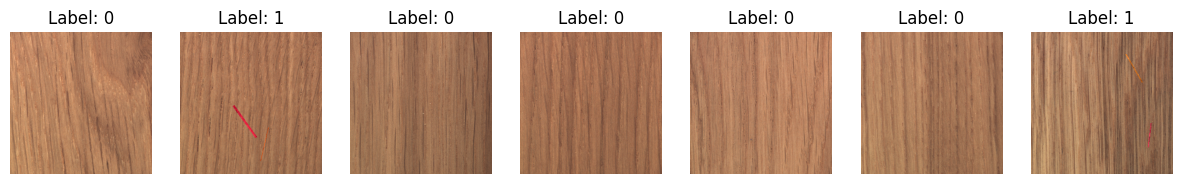

In [ ]:
# Example for separating images and labels
images, labels = zip(*list(combined_dataset_train.as_numpy_iterator()))

#resize images
images = [tf.image.resize(img, image_size).numpy() for img in images]

images_array = np.array([img for img in images])
labels_array = np.array(labels)

# Randomly select images for display
num_images_to_display = 7
random_indices = np.random.choice(len(images_array), num_images_to_display, replace=False)
random_images = images_array[random_indices]
random_labels = labels_array[random_indices]

# Show selected images
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 3))
for i, (image, label) in enumerate(zip(random_images, random_labels)):
    # Normalise pixel values to [0, 1].
    image = image / 255.0
    axes[i].imshow(image)
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')

plt.show()

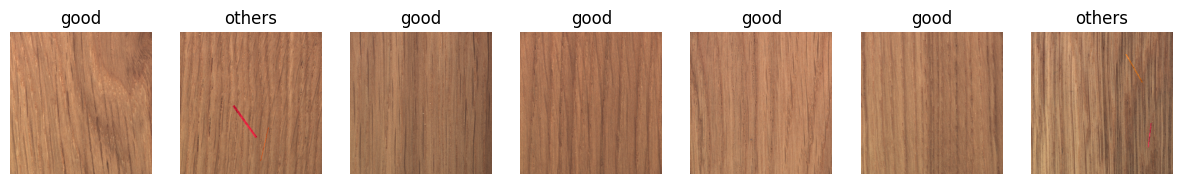

In [ ]:
class_names = {0: 'good', 1: 'others'}

# Show selected images with class names
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 3))
for i, (image, label) in enumerate(zip(random_images, random_labels)):
    image = image / 255.0  # Normalise pixel values
    axes[i].imshow(image)
    # Utilisez class_names pour obtenir le nom de la classe à partir de l'étiquette
    axes[i].set_title(f'{class_names[label]}')  # Cette ligne a été modifiée
    axes[i].axis('off')
plt.show()


#**11. Generation of training datasets**

##**11.1 train_dataset**

In [ ]:
# Creation of TensorFlow datasets for images and labels
image_dataset = tf.data.Dataset.from_tensor_slices(images_array)
label_dataset = tf.data.Dataset.from_tensor_slices(labels_array)

# Combining images and labels into a single dataset
train_dataset = tf.data.Dataset.zip((image_dataset, label_dataset))

# Mixing and batching the dataset
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size)


##**11.2 validation_dataset**

In [ ]:
# Example for separating images and labels
images, labels = zip(*list(combined_dataset_validation.as_numpy_iterator()))

#resize images
images = [tf.image.resize(img, image_size).numpy() for img in images]

images_array = np.array([img for img in images])
labels_array = np.array(labels)

# Conversion of lists into NumPy arrays for images and validation labels
val_images_array = np.array(images)
val_labels_array = np.array(labels)

# Creation of TensorFlow datasets for images and validation labels
val_image_dataset = tf.data.Dataset.from_tensor_slices(val_images_array)
val_label_dataset = tf.data.Dataset.from_tensor_slices(val_labels_array)

# Combining images and labels into a single validation dataset
validation_dataset = tf.data.Dataset.zip((val_image_dataset, val_label_dataset))

# Mixing and batching the validation dataset
validation_dataset = validation_dataset.shuffle(buffer_size=1000).batch(batch_size)

##**11.3 Weight distribution on class imbalance**

In [ ]:
#calculate class weight to handle class imbalance

# Calculate class frequencies
class_counts = np.bincount(labels_array)

# Compute class weights
total_samples = np.sum(class_counts)
class_weights = {class_idx: total_samples / (len(class_counts) * count) for class_idx, count in enumerate(class_counts)}

print("Class counts:", class_counts)
print("Class weights:", class_weights)

Class counts: [24 18]
Class weights: {0: 0.875, 1: 1.1666666666666667}


#**12. CutPaste model drive**

##**12.1 Initialisation of the feature extraction model**

In [ ]:
if classifier in model_loaders:
    base_model = model_loaders[classifier](weights='imagenet',
                                           include_top=False,
                                           input_tensor=None,
                                           input_shape=(image_size[0],
                                                        image_size[1], 3))
else:
    raise ValueError(f"Unsupported classifier: {classifier}")

94765736/94765736 [==============================] - 3s 0us/step


##**12.2 Generating the model to be loaded**

In [ ]:
# Add custom classification layer on top of ResNet backbone
x = base_model.output

# Use GlobalAveragePooling2D to reduce dimensionality
x = layers.GlobalAveragePooling2D()(x)

# Dynamically creates dense layers as specified in head_layers
head_layers = [nb_nodes]*head_layer+[last_level]

for num_neurons in head_layers:
    x = layers.Dense(num_neurons)(x)  # Adds a Dense layer
    x = layers.BatchNormalization()(x)  # Followed by Batch Normalization
    x = layers.ReLU()(x)  # Followed by a ReLU activation
#    x = layers.Dropout(dropout_rate)(x)  # Adds Dropout after activation

#output = layers.Dense(1, activation='sigmoid', kernel_regularizer=l2(l2_rate))(x)
output = layers.Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=output)

##**12.3 Imagenet layer freeze**

In [ ]:
#freeze
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
# Affichage de l'état gelé de chaque couche
for layer in base_model.layers:
    print(f'{layer.name}: {"trainable" if layer.trainable else "not trainable"}')

input_1: not trainable
conv1_pad: not trainable
conv1_conv: not trainable
conv1_bn: not trainable
conv1_relu: not trainable
pool1_pad: not trainable
pool1_pool: not trainable
conv2_block1_1_conv: not trainable
conv2_block1_1_bn: not trainable
conv2_block1_1_relu: not trainable
conv2_block1_2_conv: not trainable
conv2_block1_2_bn: not trainable
conv2_block1_2_relu: not trainable
conv2_block1_0_conv: not trainable
conv2_block1_3_conv: not trainable
conv2_block1_0_bn: not trainable
conv2_block1_3_bn: not trainable
conv2_block1_add: not trainable
conv2_block1_out: not trainable
conv2_block2_1_conv: not trainable
conv2_block2_1_bn: not trainable
conv2_block2_1_relu: not trainable
conv2_block2_2_conv: not trainable
conv2_block2_2_bn: not trainable
conv2_block2_2_relu: not trainable
conv2_block2_3_conv: not trainable
conv2_block2_3_bn: not trainable
conv2_block2_add: not trainable
conv2_block2_out: not trainable
conv2_block3_1_conv: not trainable
conv2_block3_1_bn: not trainable
conv2_block3_

##**12.4 Early Stopping**

In [ ]:
!mkdir -p model
model_path = "model/best_model.h5"

In [ ]:
early_stopping = EarlyStopping(patience=early_patience,
                               restore_best_weights=True)

checkpoint = ModelCheckpoint(model_path,
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max', # Ensure that the best model in terms of val_accuracy is saved
                             verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7,
                              patience=5, min_lr=0.005)

##**12.5 Compile**

In [ ]:
lr_schedule = ExponentialDecay( initial_learning_rate=sgd_initial_learning_rate,
                               decay_steps=10000,
                                decay_rate=0.9)

optimizer = SGD(learning_rate=lr_schedule, momentum=0.9)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

##**12.6 Execute**

In [ ]:
callbacks_list = [early_stopping, checkpoint,reduce_lr]

history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=callbacks_list)

Epoch 1/100
25/25 [==============================] - ETA: 0s - loss: 0.4717 - accuracy: 0.7724
Epoch 1: val_accuracy improved from -inf to 0.52381, saving model to model/best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 14s 160ms/step - loss: 0.4717 - accuracy: 0.7724 - val_loss: 0.6275 - val_accuracy: 0.5238 - lr: 9.9975e-04
Epoch 2/100
25/25 [==============================] - ETA: 0s - loss: 0.1953 - accuracy: 0.9437
Epoch 2: val_accuracy improved from 0.52381 to 0.95238, saving model to model/best_model.h5
25/25 [==============================] - 2s 70ms/step - loss: 0.1953 - accuracy: 0.9437 - val_loss: 0.4847 - val_accuracy: 0.9524 - lr: 9.9948e-04
Epoch 3/100
25/25 [==============================] - ETA: 0s - loss: 0.1629 - accuracy: 0.9565
Epoch 3: val_accuracy did not improve from 0.95238
25/25 [==============================] - 1s 43ms/step - loss: 0.1629 - accuracy: 0.9565 - val_loss: 0.3655 - val_accuracy: 0.9286 - lr: 9.9922e-04
Epoch 4/100
25/25 [==============================] - ETA: 0s - loss: 0.1278 - accuracy: 0.9668
Epoch 4: val_accuracy did not improve from 0.95238
25/25 [==============================] - 1s 42ms/step - loss: 0.1278 - accurac

##**12.7 Training results**

In [ ]:
val_loss, val_accuracy = model.evaluate(validation_dataset)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

3/3 [==============================] - 0s 26ms/step - loss: 0.0351 - accuracy: 1.0000
Validation Loss: 0.03507649153470993
Validation Accuracy: 1.0


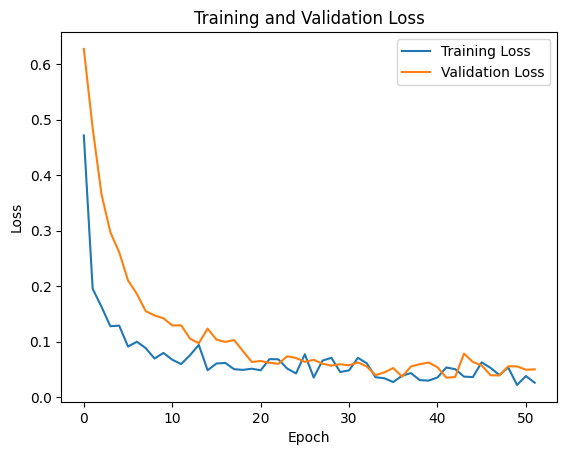

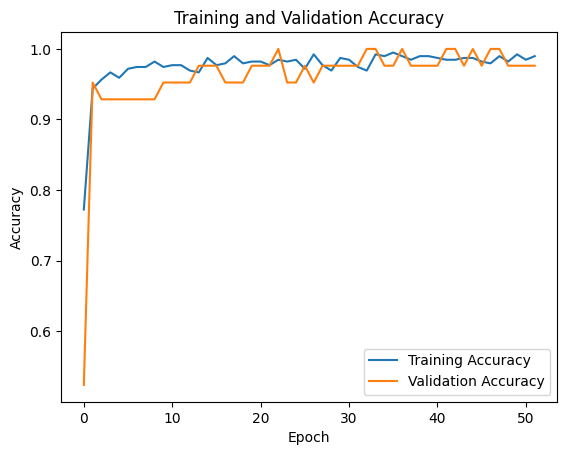

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **13. Model test**

##**13.1 Creating the test data set**

In [ ]:
# Create the dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    labels='inferred',
    label_mode='int',
    class_names=None,  # Automatically infer class names
    color_mode='rgb',
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=123
)

# Manually assign labels: 0 for 'good', 1 for others
class_names = test_dataset.class_names
print("Class names test_dataset:", class_names)

Found 79 files belonging to 6 classes.
Class names test_dataset: ['color', 'combined', 'good', 'hole', 'liquid', 'scratch']


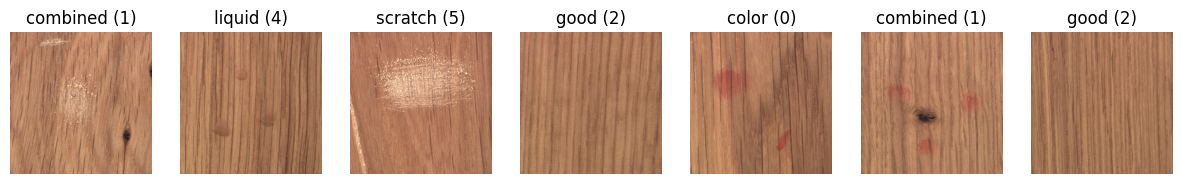

In [ ]:
# Take a batch of images and labels from the test dataset
for images, labels in test_dataset.take(1):  # Take one batch from the dataset
    break  # We just need the first batch

# Ensure that we have at least 7 images in the batch
assert len(images) >= 7, "The batch does not contain enough images."

# Choose the first 7 images and labels from the batch
images_to_display = images[:7]
labels_to_display = labels[:7]

# Create a figure to display the images
plt.figure(figsize=(15, 3))

# Display each of the 7 images
for i in range(7):
    plt.subplot(1, 7, i+1)
    plt.imshow(images_to_display[i].numpy().astype("uint8"))
    # Get the class name using the label
    class_name = class_names[labels_to_display[i].numpy()]
    # Display the class name and its corresponding label
    plt.title(f'{class_name} ({labels_to_display[i].numpy()})')
    plt.axis('off')

# Show the plot
plt.show()

In [ ]:
# Get the class names and find the index of 'good'
class_names = test_dataset.class_names
index_of_good = class_names.index('good')

# Manually assign labels: 0 for 'good', 1 for others
test_dataset = test_dataset.map(lambda x, y: (x, tf.where(tf.equal(y, index_of_good), 0, 1)))
binary_class_names = ['good', 'others']

# Print the binary class names and number of classes
print("Class names binary:", binary_class_names)
print("Number of classes:", len(binary_class_names))


Class names binary: ['good', 'others']
Number of classes: 2


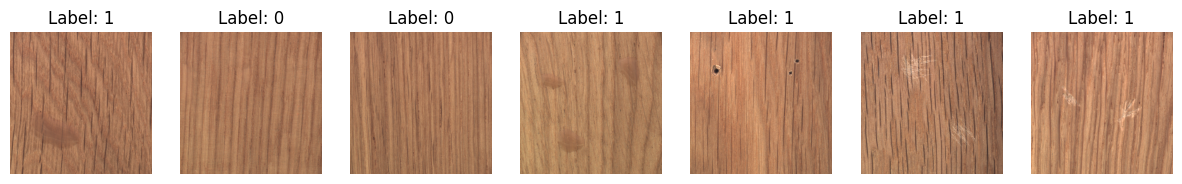

In [ ]:
# Separate images and labels
images = []
labels = []

for image_batch, label_batch in test_dataset:
    images.extend(image_batch)
    labels.extend(label_batch)

images_array = np.array(images)
labels_array = np.array(labels)

# Randomly select images for display
num_images_to_display = 7
random_indices = np.random.choice(len(images_array), num_images_to_display, replace=False)
random_images = images_array[random_indices]
random_labels = labels_array[random_indices]

# Show selected images
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 3))
for i, (image, label) in enumerate(zip(random_images, random_labels)):
    # Normalise pixel values to [0, 1].
    image = image / 255.0
    axes[i].imshow(image)
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')

plt.show()

##**13.2 Display examples of test images**

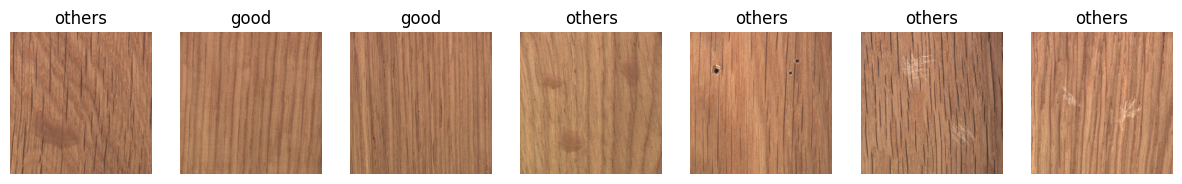

In [ ]:
# Show selected images with class names
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 3))
for i, (image, label) in enumerate(zip(random_images, random_labels)):
    image = image / 255.0  # Normalise pixel values
    axes[i].imshow(image)
    # Utilisez class_names pour obtenir le nom de la classe à partir de l'étiquette
    axes[i].set_title(f'{binary_class_names[label]}')  # Cette ligne a été modifiée
    axes[i].axis('off')
plt.show()

##**13.3 Evaluation of the test dataset**

In [ ]:
best_model = load_model(model_path)

# Evaluate the model
loss, accuracy = best_model.evaluate(test_dataset)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


5/5 [==============================] - 5s 193ms/step - loss: 0.2160 - accuracy: 0.9241
Test Loss: 0.2159748524427414
Test Accuracy: 0.9240506291389465


##**13.4 Prediction test**

In [ ]:
test_predictions = model.predict(test_dataset)

5/5 [==============================] - 3s 22ms/step


1/1 [==============================] - 1s 1s/step


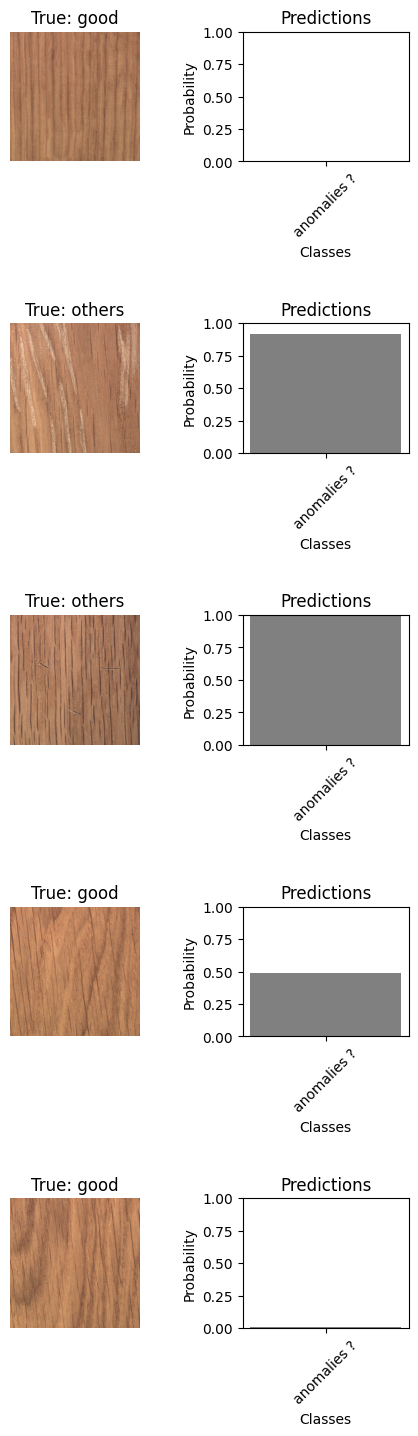

1/1 [==============================] - 0s 31ms/step


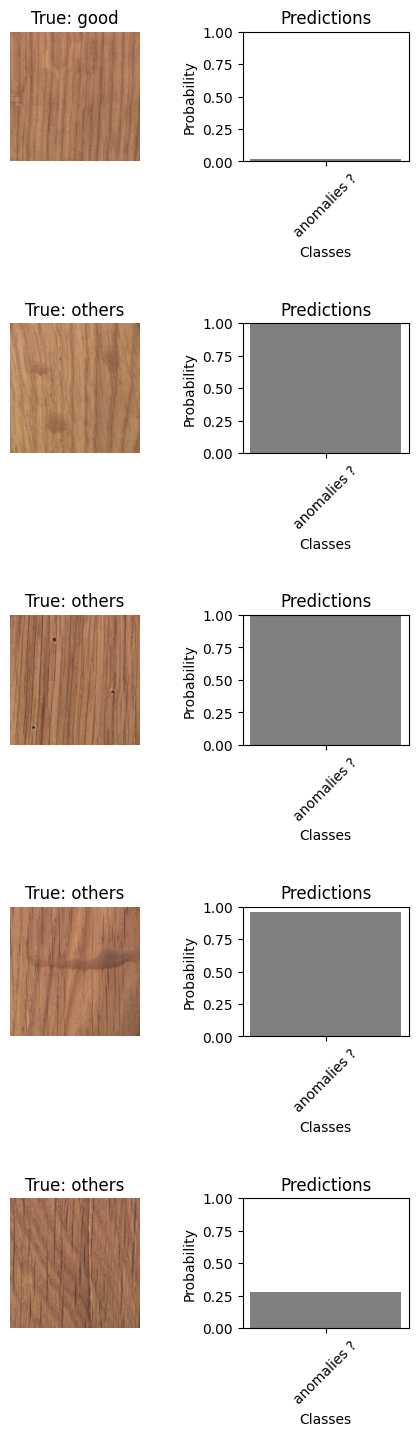

1/1 [==============================] - 0s 55ms/step


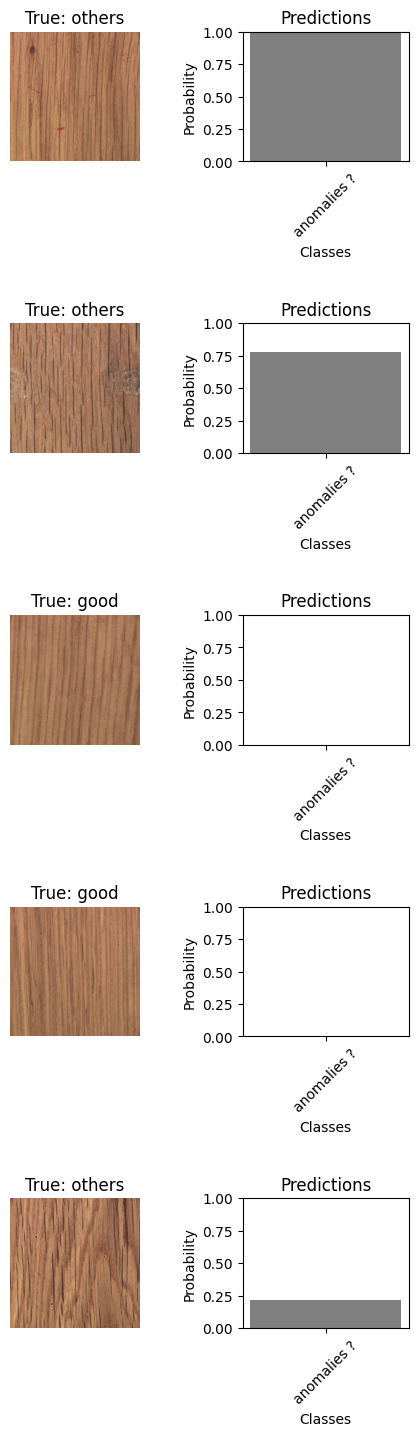

1/1 [==============================] - 0s 54ms/step


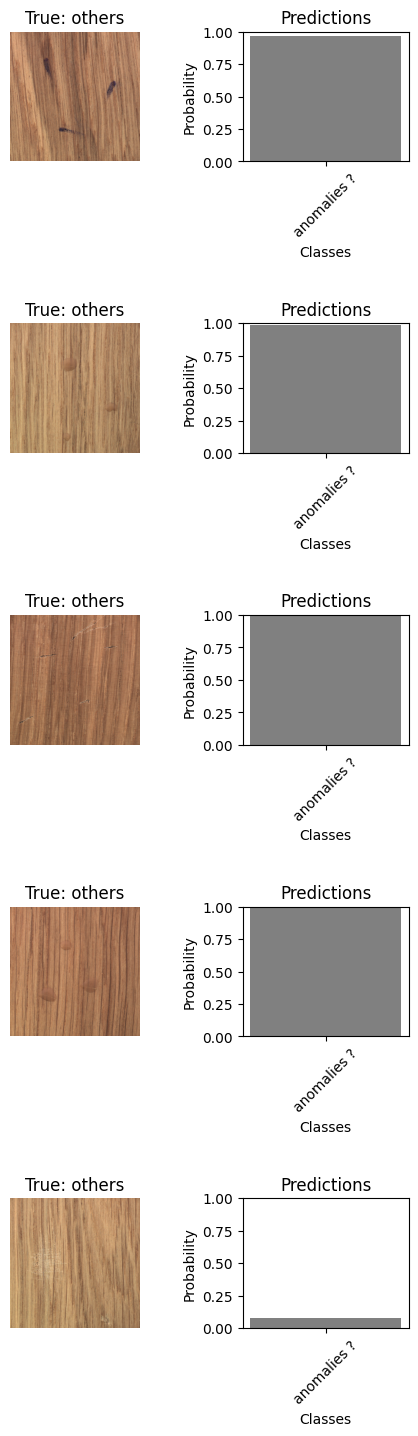

1/1 [==============================] - 0s 40ms/step


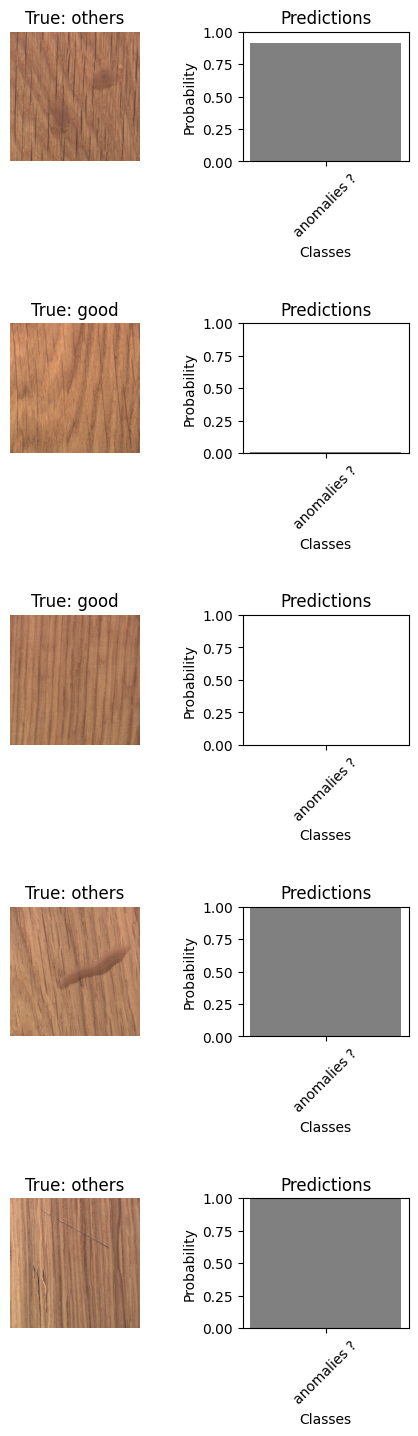

In [ ]:
# Define a function to plot images and their predictions
def plot_images_with_predictions(images, labels, predictions, class_names, num_images=5):
    num_images = min(num_images, images.shape[0])

    plt.figure(figsize=(5, 3*num_images))
    for i in range(num_images):
        plt.subplot(num_images, 2, 2*i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True: {class_names[labels[i]]}")
        plt.axis("off")

        # Plot a single bar chart for the prediction
        plt.subplot(num_images, 2, 2*i + 2)
        plt.bar("anomalies ?", predictions[i], color='gray')
        plt.title("Predictions")
        plt.xlabel("Classes")
        plt.ylabel("Probability")
        plt.xticks(rotation=45)
        plt.ylim([0, 1])  # Set y-axis limits to [0, 1]
        plt.tight_layout(pad=3.0)

    plt.show()

# Get a batch of images, labels, and predictions from the test dataset
for images, labels in test_dataset:
    # Make predictions using the trained model
    predictions = model.predict(images)

    # Plot the images and their predictions
    plot_images_with_predictions(images, labels, predictions, binary_class_names)


3/3 [==============================] - 2s 29ms/step


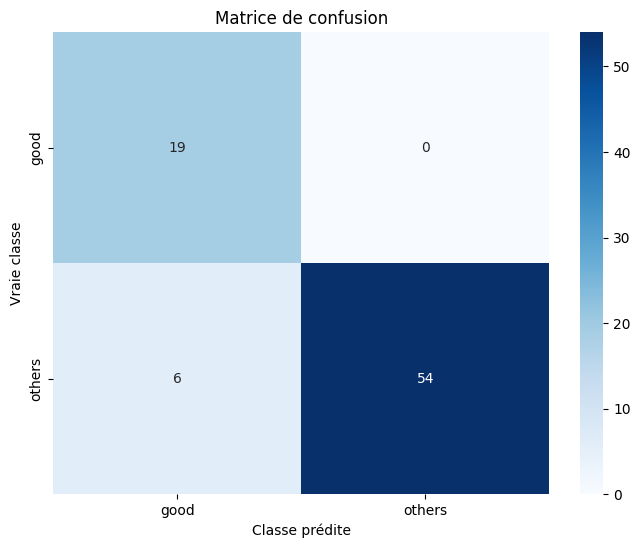

In [ ]:
# Préparer les données de test pour la prédiction
x_test = []
y_true = []

for images, labels in test_dataset.unbatch().batch(32):  # Ajustement pour unbatch puis batch pour la prédiction
    x_test.append(images.numpy())
    y_true.extend(labels.numpy())

x_test = np.concatenate(x_test, axis=0)

# Prédire les classes pour les données de test
y_pred_probs = best_model.predict(x_test)  # Assurez-vous que le modèle retourne la probabilité de 'others'
y_pred = (y_pred_probs > 0.5).astype(int)  # Si probabilité > 0.5, classez comme 'others', sinon 'good'


# Calculer la matrice de confusion
cm = confusion_matrix(y_true, y_pred)

# Afficher la matrice de confusion avec les nouvelles classes 'good' et 'others'
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=binary_class_names, yticklabels=binary_class_names)
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.title('Matrice de confusion')
plt.show()

#**14. Sauvegarde du model**

In [ ]:
model_name = f"model-{type}" + '-{date:%Y-%m-%d_%H_%M_%S}'.format(date=datetime.datetime.now() )
model_path_drive = os.path.join(models_path, model_name)
best_model.save(model_path_drive)  # Save the best model to Google Drive
best_model.save(f"{model_path_drive}.h5")  # Save the best model to Google Drive

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
print(model_path_drive)

/content/drive/MyDrive/francesco/CutPaste/models/model-wood-2024-04-14_18_09_22


#**15. Detecting anomalies on embendings**

Good explanation by Lilit Yolyan in this [link](https://towardsdatascience.com/kernel-density-estimation-for-anomaly-detection-in-python-part-1-452c5d4c32ec) and in this [link](https://towardsdatascience.com/self-supervised-learning-for-anomaly-detection-in-python-part-2-5c918b12a1bc)

This code includes the steps of extracting embeddings from the pre-trained model, fitting GaussianDensitySklearn on these embeddings, and then using the fitted density model to obtain density scores for a new data set. These scores can then be used to identify anomalies, for example, by choosing a threshold below which an observation is considered anomalous.

In [ ]:
if type == "all":
  types = all_types
else:
  types = type.split(",")

print(types)

# find models
model_names = [list(Path(models_path).glob(f"model-{type}*"))[0] for type in types if len(list(Path(models_path).glob(f"model-{type}*"))) > 0]
if len(model_names) < len(all_types):
  print("warning: not all types present in folder")
print(model_names)

['wood']
[PosixPath('/content/drive/MyDrive/francesco/CutPaste/models/model-wood-2024-04-05_12_48_22')]


## **15.1 Image-level**

Here, what we will do is the following: use the trained CNN model (without last classfication layer) to extract an embedding vector from the images. Then, train a Gaussian Density Estimator to these embeddings. Compute the log-density using the Gaussian Distributions (from equation (2) if the paper).



In [ ]:
# #load previously trained model
# loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/francesco/CutPaste/models/model-wood-2024-04-13_19_28_20.h5")

In [ ]:
# model.load_weights("/content/drive/MyDrive/francesco/CutPaste/models/model-wood-2024-04-13_19_28_20.h5")
model.load_weights("/content/drive/MyDrive/francesco/CutPaste/models/model-wood-2024-04-14_15_28_43.h5")

feature_extractor = Model(inputs = model.input, outputs = model.layers[-2].output )

In [ ]:
# print(loaded_model)

In [ ]:
# # Remove the last layer
# feature_extractor = tf.keras.Model(inputs=loaded_model.input, outputs=loaded_model.layers[-2].output)

In [ ]:
print(feature_extractor.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
# Function for extracting embeddings from the ResNet50 model
def get_embeddings(model, dataset):
    all_embeddings = []
    y_label = []
    raw_images = []

    for images, labels in dataset:
        # Obtain embeddings
        embeddings = model.predict(images)
        all_embeddings.extend(embeddings)
        y_label.extend(labels.numpy())
        raw_images.extend(images.numpy())
    return np.array(all_embeddings), np.array(y_label), np.array(raw_images)

In [ ]:
#train_dataset_good: train dataset with no augmentation
train_embeddings, y_label_train, raw_train = get_embeddings(feature_extractor, train_dataset_good)
test_embeddings, y_label_test, raw_test = get_embeddings(feature_extractor, test_dataset)

1/1 [==============================] - 0s 33ms/step


In [ ]:
print(train_embeddings.shape)

(223, 128)


In [ ]:
from sklearn.neighbors import KernelDensity


# Fit Kernel Density Estimation
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(train_embeddings)

KernelDensity()

In [ ]:
# Score anomalies
density_estimate = kde.score_samples(test_embeddings)
norm = np.linalg.norm(-density_estimate)
score = -density_estimate/norm
print(score)

[0.11658454 0.11431318 0.11323408 0.11240576 0.09909136 0.11829879
 0.09405171 0.10814102 0.09348765 0.10856743 0.10669123 0.09464991
 0.10447218 0.10437726 0.12192223 0.11239601 0.10158997 0.10093859
 0.12664405 0.09865486 0.1154402  0.18690969 0.10979636 0.11399527
 0.13497746 0.11961803 0.1366114  0.09620824 0.10948023 0.11943958
 0.13440799 0.10333603 0.0921043  0.1049105  0.11248215 0.11364689
 0.10242206 0.11014605 0.09849301 0.10688072 0.11160098 0.12766699
 0.09789338 0.11637765 0.13831101 0.10893989 0.1139434  0.12369225
 0.11500334 0.12403981 0.11351515 0.16144287 0.09868462 0.09631118
 0.09196679 0.10445501 0.1104693  0.09575874 0.09775738 0.09463292
 0.09511028 0.09925217 0.09483632 0.10538721 0.12220235 0.11546075
 0.11554515 0.11939776 0.1094372  0.10048397 0.10908206 0.1090006
 0.09402783 0.15499883 0.10473324 0.11341331 0.10279327 0.12554228
 0.09369384]


We obtain 391 vectors (for the 391 images in the training set) of size 128 (output of the network is sized 128).

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt


# threshold = 0

# # Compute histogram bins and counts
# hist, bins = np.histogram(score, bins=50, density=False)

# # Assigning colors based on y_true
# colors = np.where(np.array(y_label_test) == 1, 'r', 'b')  # Assign 'r' for anomalies (y_true == 1) and 'b' for normal (y_true == 0)
# # print(colors)

# # Plotting the histogram bars with colors
# plt.figure(figsize=(10, 6))
# plt.bar(bins[:-1], hist, width=np.diff(bins), color=colors, alpha=0.5)

# # # Plot the threshold line
# # plt.axvline(x=threshold, color='g', linestyle='--', label='Threshold')

# # Labeling
# plt.xlabel('Density Estimate')
# plt.ylabel('Number of predictions')
# plt.title('Histogram with Bar Coloring based on Labels')
# # plt.legend(['Threshold'])
# plt.show()


to the above graph, something to add: color of the label !! (normal or anomaly) to see if the model is able to detect the anomaly

## **Anomaly score**


The Receiver Operating Characteristic (ROC) curve is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. However, it's important to note that the ROC curve can still be useful even if you're not explicitly thresholding your anomaly scores.

When you have non-thresholded anomaly scores, the ROC curve essentially shows the trade-off between the true positive rate (TPR) and the false positive rate (FPR) across all possible thresholds. Each point on the ROC curve represents a different threshold level for classifying anomalies.

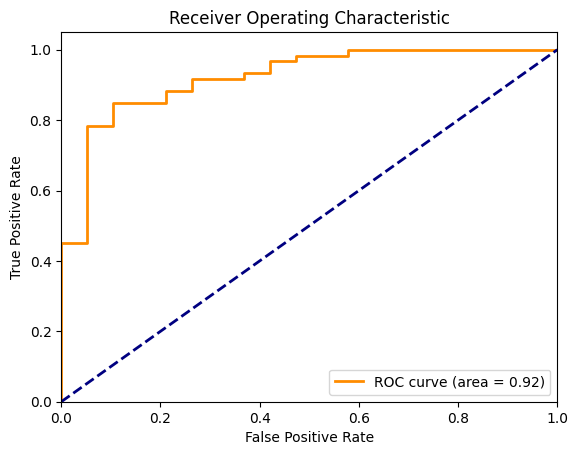

AUC: 0.9219298245614036


In [ ]:
from sklearn.metrics import roc_curve, auc


fpr, tpr, thresholds  = roc_curve(y_label_test, score)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("AUC:", roc_auc)

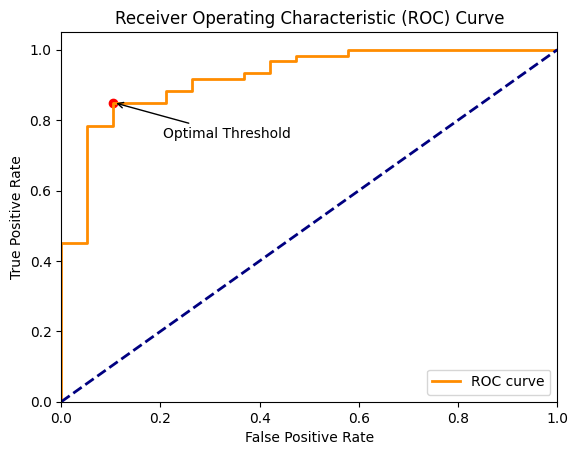

Optimal Threshold: 0.10437725510042664


In [ ]:
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Find the point closest to the top-left corner
closest_point_idx = np.argmax(tpr - fpr)
closest_point = (fpr[closest_point_idx], tpr[closest_point_idx])

# Plot the point
plt.scatter(closest_point[0], closest_point[1], c='red', marker='o')
plt.annotate('Optimal Threshold', xy=closest_point, xytext=(closest_point[0] + 0.1, closest_point[1] - 0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.show()

# Print the coordinates of the optimal threshold
optimal_threshold = thresholds[closest_point_idx]
print("Optimal Threshold:", optimal_threshold)

In [ ]:
from sklearn.metrics import roc_curve, auc

# Choose a threshold
threshold = 0.1

# Assign labels based on the threshold
predicted_labels = (score > threshold).astype(int)  # 1 for anomalies, 0 for normal instances
accuracy = np.mean(predicted_labels == y_label_test)
print("Accuracy:", accuracy)

Accuracy: 0.8607594936708861


In [ ]:
# # Calculer la matrice de confusion
# cm = confusion_matrix(y_label_test, predicted_labels)

# # Afficher la matrice de confusion avec les nouvelles classes 'good' et 'others'
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=binary_class_names, yticklabels=binary_class_names)
# plt.ylabel('Vraie classe')
# plt.xlabel('Classe prédite')
# plt.title('Matrice de confusion')
# plt.show()

## avec train augmenté - exemple

In [ ]:
#train_dataset_good: train dataset with no augmentation
train_embeddings, y_label_train, raw_train = get_embeddings(feature_extractor, train_dataset_good)
train_augmenté_embeddings, y_label_train_augmenté, raw_train_augmenté = get_embeddings(feature_extractor, train_augmenté)
test_embeddings, _ , raw_test = get_embeddings(feature_extractor, test_dataset)

1/1 [==============================] - 0s 33ms/step


In [ ]:
print(train_embeddings.shape)

(223, 128)


In [ ]:
from sklearn.neighbors import KernelDensity


# Fit Kernel Density Estimation
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(train_embeddings)

KernelDensity()

In [ ]:
# Score anomalies
density_estimate = kde.score_samples(train_augmenté_embeddings)
norm = np.linalg.norm(-density_estimate)
score = -density_estimate/norm
print(score)

[0.11658454 0.11431318 0.11323408 0.11240576 0.09909136 0.11829879
 0.09405171 0.10814102 0.09348765 0.10856743 0.10669123 0.09464991
 0.10447218 0.10437726 0.12192223 0.11239601 0.10158997 0.10093859
 0.12664405 0.09865486 0.1154402  0.18690969 0.10979636 0.11399527
 0.13497746 0.11961803 0.1366114  0.09620824 0.10948023 0.11943958
 0.13440799 0.10333603 0.0921043  0.1049105  0.11248215 0.11364689
 0.10242206 0.11014605 0.09849301 0.10688072 0.11160098 0.12766699
 0.09789338 0.11637765 0.13831101 0.10893989 0.1139434  0.12369225
 0.11500334 0.12403981 0.11351515 0.16144287 0.09868462 0.09631118
 0.09196679 0.10445501 0.1104693  0.09575874 0.09775738 0.09463292
 0.09511028 0.09925217 0.09483632 0.10538721 0.12220235 0.11546075
 0.11554515 0.11939776 0.1094372  0.10048397 0.10908206 0.1090006
 0.09402783 0.15499883 0.10473324 0.11341331 0.10279327 0.12554228
 0.09369384]


We obtain 391 vectors (for the 391 images in the training set) of size 128 (output of the network is sized 128).

### **Anomaly score**


The Receiver Operating Characteristic (ROC) curve is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. However, it's important to note that the ROC curve can still be useful even if you're not explicitly thresholding your anomaly scores.

When you have non-thresholded anomaly scores, the ROC curve essentially shows the trade-off between the true positive rate (TPR) and the false positive rate (FPR) across all possible thresholds. Each point on the ROC curve represents a different threshold level for classifying anomalies.

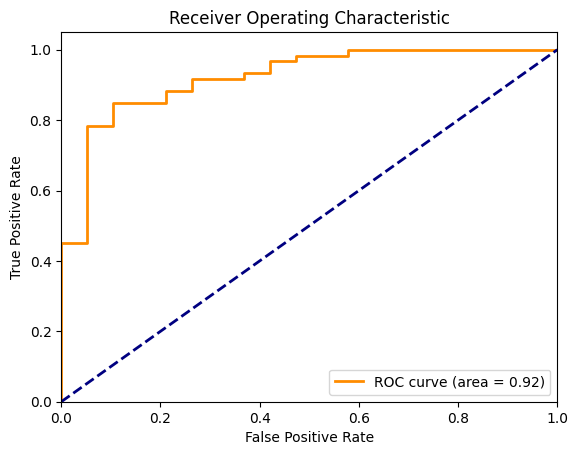

AUC: 0.9219298245614036


In [ ]:
from sklearn.metrics import roc_curve, auc


fpr, tpr, thresholds  = roc_curve(y_label_train_augmenté, score)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("AUC:", roc_auc)

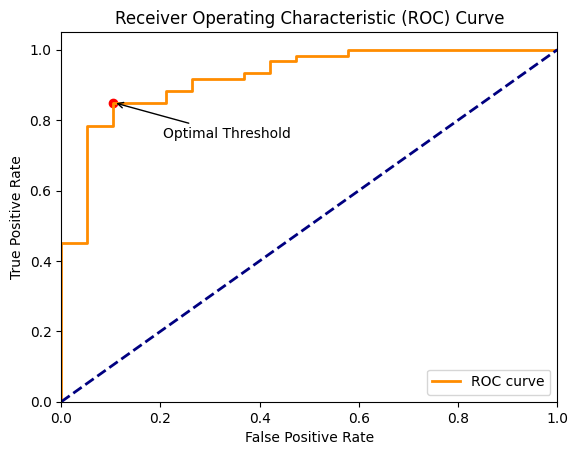

Optimal Threshold: 0.10437725510042664


In [ ]:
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Find the point closest to the top-left corner
closest_point_idx = np.argmax(tpr - fpr)
closest_point = (fpr[closest_point_idx], tpr[closest_point_idx])

# Plot the point
plt.scatter(closest_point[0], closest_point[1], c='red', marker='o')
plt.annotate('Optimal Threshold', xy=closest_point, xytext=(closest_point[0] + 0.1, closest_point[1] - 0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.show()

# Print the coordinates of the optimal threshold
optimal_threshold = thresholds[closest_point_idx]
print("Optimal Threshold:", optimal_threshold)

In [ ]:
from sklearn.metrics import roc_curve, auc

# Choose a threshold
threshold = optimal_threshold

# Assign labels based on the threshold
predicted_labels = (score > threshold).astype(int)  # 1 for anomalies, 0 for normal instances
accuracy = np.mean(predicted_labels == y_label_test)
print("Accuracy:", accuracy)

Accuracy: 0.8607594936708861


In [ ]:
# Score anomalies
density_estimate = kde.score_samples(test_embeddings)
norm = np.linalg.norm(-density_estimate)
score = -density_estimate/norm
print(score)


# Assign labels based on the threshold
predicted_labels = (score > threshold).astype(int)  # 1 for anomalies, 0 for normal instances
accuracy = np.mean(predicted_labels == y_label_test)
print("Accuracy:", accuracy)

## **T-sne**


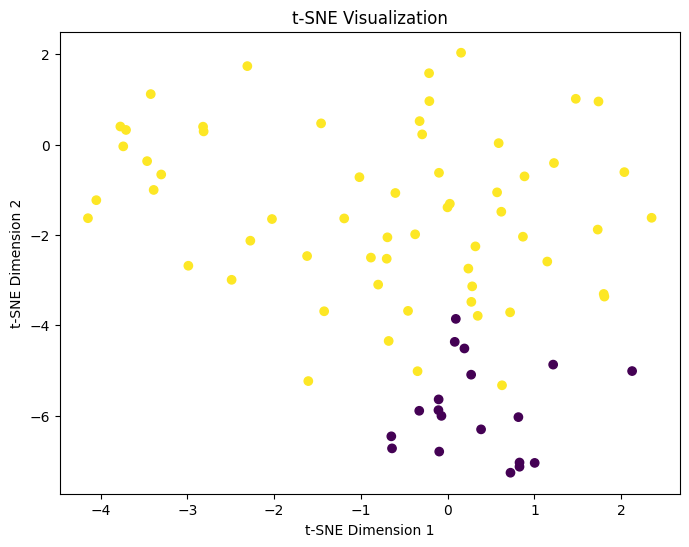

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt



#apply TSE to reduce dimensionality to 2D
tsne = TSNE(n_components=2)
tsne_embeddings = tsne.fit_transform(test_embeddings)


#visualize TSNE embeddings with labels
plt.figure(figsize=(8, 6))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=y_label_test, cmap='viridis')
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


## **Grad CAM**


In [ ]:
#inspiration from https://keras.io/examples/vision/grad_cam/ and https://stackoverflow.com/questions/66182884/how-to-implement-grad-cam-on-a-trained-network

import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)

            loss = predictions[:, tf.argmax(predictions[0])]

        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.8,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # Resize heatmap to match the dimensions of the input image
        heatmap_resized = cv2.resize(heatmap, (image.shape[2], image.shape[1]))

        # Apply the supplied color map to the heatmap
        heatmap_colored = cv2.applyColorMap(heatmap_resized, colormap)

        # Convert the heatmap and image to the same data type
        heatmap_colored = heatmap_colored.astype(np.float32)
        image = image.astype(np.float32)

        # Overlay the heatmap on the input image using the specified alpha value
        overlay = cv2.addWeighted(image[0], alpha, heatmap_colored, alpha, 0)

        # Clip the overlay to the range [0, 255] and convert it back to uint8
        overlay = np.clip(overlay, 0, 255).astype(np.uint8)

        return (heatmap_resized, overlay)

In [ ]:
# Select a random image from the test dataset
random_index = random.randint(0, len(test_dataset) - 1)
for i, (image, label) in enumerate(test_dataset):
    if i == random_index:
        selected_image = image[0]
        break
selected_image = np.expand_dims(selected_image, axis=0)  # Add a batch dimension


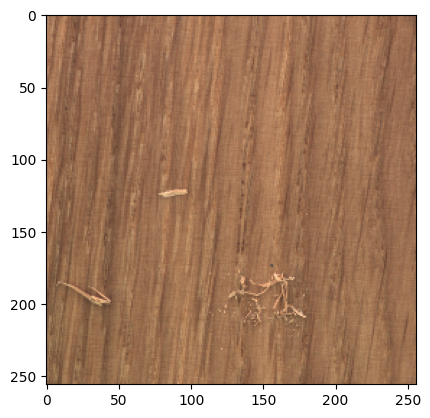

In [ ]:
plt.imshow(selected_image[0]/255)
plt.show()

heat and selected (256, 256) (1, 256, 256, 3)


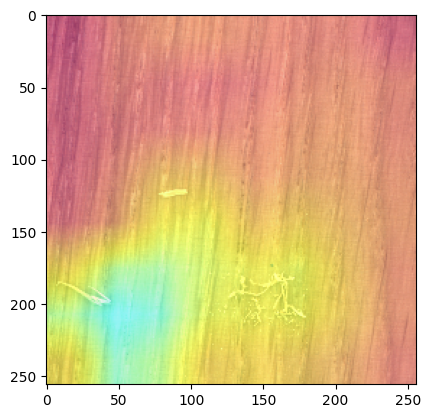

In [ ]:
# using gradcam class
grad_cam = GradCAM(model=best_model, classIdx=0)

# Compute the heatmap
heatmap = grad_cam.compute_heatmap(selected_image)
print("heat and selected", heatmap.shape, selected_image.shape)
# Overlay the heatmap on the original image
heatmap, overlay = grad_cam.overlay_heatmap(heatmap, selected_image)
# Visualize the heatmap and overlay
plt.imshow(overlay)
plt.imshow(heatmap, cmap='jet', alpha=0.05)
plt.show()

## **15.2 Patch-level**

For this, the idea will be the following: divide the input image into several small patches: we train models of 64x64 patches from 256x256 images. At test time, we densely extract anomaly scores with a stride of 4 and propagate the anomaly scores via reception field upsampling with gaussian smoothing


**from the paper**:

CutPaste prediction is readily applicable to learn a patch
representation – all we need to do at training is to crop a
patch before applying CutPaste augmentation At test
time, we extract embeddings from all patches with a given
stride. For each patch, we evaluate its anomaly score and
use a Gaussian smoothing to propagate the score to every
pixel [32]. In Section 4.2, we visualize a heatmap using
patch-level detector for defect localization

So, we will have to redo cutpaste augmentation on patches of the images :)



### **15.2.1. Dataset augmentation on patches**

In [ ]:
def augment_dataset_on_patch(dataset, image_size, image_augmented_instance, intlabel, nb_images_augmented=4):
    cutpaste_augmented_dataset = []

    # Desired crop size, for example, a square slightly smaller than the original image
    crop_size = [128, 128, 3]  # Size of the patches to extract

    # Iterate over batch
    for batch_image, labels in dataset:  # 32 images by default
        # Iterate over images in batch
        # print(batch_image.shape)
        for image, label in zip(batch_image, labels):
            # print(image.shape)
            # # Plot original image
            # plt.figure(figsize=(8, 8))
            # plt.subplot(5, 1, 1)  # Adjust subplot parameters as needed
            # plt.imshow(image/255)
            # plt.title('Original Image')
            # plt.axis('off')
            # Extract 4 patches of size 128x128 from the 256x256 image
            patches = tf.image.extract_patches(
                images=tf.expand_dims(image, axis=0),  # Add batch dimension
                sizes=[1, crop_size[0], crop_size[1], 1],
                strides=[1, 128, 128, 1],  # Stride equal to patch size for non-overlapping patches
                rates=[1, 1, 1, 1],
                padding='VALID'
            )
            # print(patches.shape)
            patches = tf.reshape(patches, [4, crop_size[0], crop_size[1], 3])  # Reshape to 4 patches
            # print(patches.shape)
            # Apply augmentation to each patch
            # Plot extracted patches
            for i, patch in enumerate(patches):
                # plt.subplot(5, 1, i + 2)  # Adjust subplot parameters as needed
                # plt.imshow(patch/255)
                # plt.title(f'Patch {i+1}')
                # plt.axis('off')

                cutpaste_augmented_dataset.append((patch, 0))  # Append normal patch with label
                # Apply further increases if necessary
                augmented_patch = image_augmented_instance(patch)
                cutpaste_augmented_dataset.append((augmented_patch, intlabel))  # Append augmented patch with label

    return cutpaste_augmented_dataset

###**15.2.2 CutPastePatch**

###**15.2.3 CutPaste augmented training dataset**

In [ ]:
# Using the function to increase the train_dataset with CutPaste
cutpaste_augmented_dataset_on_patch = augment_dataset_on_patch(train_dataset_good, image_size, cutpaste_patch_instance, 1)

In [ ]:
print(len(cutpaste_augmented_dataset_on_patch))

In [ ]:
# Separate images and labels
images = []
labels = []

for image_batch, label_batch in cutpaste_augmented_dataset_on_patch:
    images.append(image_batch)
    labels.append(label_batch)

images_array = np.array(images)
labels_array = np.array(labels)

# Randomly select images for display
num_images_to_display = 7
random_indices = np.random.choice(len(cutpaste_augmented_dataset_on_patch), num_images_to_display, replace=False)
random_images = images_array[random_indices]
random_labels = labels_array[random_indices]

# Show selected images
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 3))
for i, (image, label) in enumerate(zip(random_images, random_labels)):
    # Normalise pixel values to [0, 1].
    image = image / 255.0
    axes[i].imshow(image)
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')

plt.show()


###**15.2.4 CutPaste augmented validation dataset**

In [ ]:
# Using the function to increase the validation_dataset with CutPaste
cutpaste_augmented_dataset_validation_on_patch = augment_dataset_on_patch(validation_dataset_good, image_size, cutpaste_patch_instance, 1)

###**15.2.5 ScarPatch**

In [ ]:
#Patch height
min_scar_height_patch = 10  # @param [10, 15,20] {type:"raw"}
max_scar_height_patch = 35  # @param [25,30,35,50,75, 150] {type:"raw"}

#Patch width
min_scar_width_patch = 1  # @param [1,2,3] {type:"raw"}
max_scar_width_patch = 5  # @param [5,7,10,16] {type:"raw"}

num_scars = 4  # @param [1,2,3,4,5] {type:"raw"}

# Direct definition of parameters as values in the aspect_scar_patch dictionary
aspect_scar_patch = {
    "min_h_scar": min_scar_height_patch,
    "max_h_scar": max_scar_height_patch,
    "min_w_scar": min_scar_width_patch,
    "max_w_scar": max_scar_width_patch
}

In [ ]:
scar_patch_instance = ScarPatch(aspect_scar_patch=aspect_scar_patch,
                                num_scars=num_scars,
                                color_jitter=color_jitter,
                                transforms=[rotate_image_randomly]
)

###**15.2.6 Scar augmented training dataset**

In [ ]:
# Using the function to increase the train_dataset with Scar
scar_augmented_dataset_on_patch = augment_dataset_on_patch(train_dataset_good, image_size, scar_patch_instance, 1)

In [ ]:
# Separate images and labels
images = []
labels = []

for image_batch, label_batch in scar_augmented_dataset_on_patch:
    images.append(image_batch)
    labels.append(label_batch)

images_array = np.array(images)
labels_array = np.array(labels)

# Randomly select images for display
num_images_to_display = 7
random_indices = np.random.choice(len(images_array), num_images_to_display, replace=False)
random_images = images_array[random_indices]
random_labels = labels_array[random_indices]

# Show selected images
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 3))
for i, (image, label) in enumerate(zip(random_images, random_labels)):
    # Normalise pixel values to [0, 1].
    image = image / 255.0
    axes[i].imshow(image)
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')

plt.show()


###**15.2.7 Scar augmented validation dataset**

In [ ]:
# Using the function to increase the validation_dataset with Scar
scar_augmented_dataset_validation_on_patch = augment_dataset_on_patch(validation_dataset_good, image_size, scar_patch_instance, 1)

###**15.2.8 CutOutPatch**

###**15.2.9 CutOutPatch instance**

In [ ]:
cutout_patch_instance = CutOutPatch(area_ratio=area_ratio,
                                    aspect_ratio=aspect_ratio,
                                    color_jitter=color_jitter
)

###**15.2.10 CutOut augmented training dataset**

In [ ]:
# Using the function to increase the train_dataset with Scar
cutout_augmented_dataset_on_patch = augment_dataset_on_patch(train_dataset_good, image_size, cutout_patch_instance, 1)

###**15.2.11 CutOut augmented validation dataset**

In [ ]:
# Using the function to increase the validation_dataset with Scar
cutout_augmented_dataset_validation_on_patch = augment_dataset_on_patch(validation_dataset_good, image_size, cutout_patch_instance, 1)

###**15.2.12. Flattening the combination of normal and augmented images**

###**15.2.13 combined_dataset_train**

In [ ]:
if balanced_normal_others == 1:
    division_factor = 2**nb_images_augmented
else:
    division_factor = 1  # If equity is not equal to 1, no division

# # Convert BatchDataset to FlatMapDataset
# train_dataset_flat_good = train_dataset_good.flat_map(lambda x, y: tf.data.Dataset.from_tensor_slices((x, y)))

# Concatenate the datasets
# cutpaste_augmented_dataset_train_on_patch = tf.data.Dataset.from_generator(lambda: cutpaste_augmented_dataset_on_patch, output_types=(tf.float32, tf.int32)).shard(num_shards=division_factor, index=0)
# scar_augmented_dataset_train_on_patch = tf.data.Dataset.from_generator(lambda: scar_augmented_dataset_on_patch, output_types=(tf.float32, tf.int32)).shard(num_shards=division_factor, index=0)
# combined_augmented_dataset_train_on_patch = cutpaste_augmented_dataset_train_on_patch.concatenate(scar_augmented_dataset_train_on_patch)
combined_dataset_train_on_patch = cutpaste_augmented_dataset_on_patch + scar_augmented_dataset_on_patch + cutout_augmented_dataset_on_patch
# combined_dataset_train_on_patch = combined_augmented_dataset_train_on_patch.shuffle(buffer_size=1000)


In [ ]:
# Separate images and labels
images = []
labels = []

for image_batch, label_batch in combined_dataset_train_on_patch:
    images.append(image_batch)
    labels.append(label_batch)

images_array = np.array(images)
labels_array = np.array(labels)

# Randomly select images for display
num_images_to_display = 7
random_indices = np.random.choice(len(images_array), num_images_to_display, replace=False)
random_images = images_array[random_indices]
random_labels = labels_array[random_indices]

# Show selected images
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 3))
for i, (image, label) in enumerate(zip(random_images, random_labels)):
    # Normalise pixel values to [0, 1].
    image = image / 255.0
    axes[i].imshow(image)
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')

plt.show()


###**15.2.14 combined_dataset_validation**

In [ ]:
combined_dataset_validation_on_patch = cutpaste_augmented_dataset_validation_on_patch + scar_augmented_dataset_validation_on_patch + cutout_augmented_dataset_validation_on_patch

In [ ]:
# Separate images and labels
images = []
labels = []

for image_batch, label_batch in combined_dataset_validation_on_patch:
    images.append(image_batch)
    labels.append(label_batch)

images_array = np.array(images)
labels_array = np.array(labels)
print(labels)
# Randomly select images for display
num_images_to_display = 7
random_indices = np.random.choice(len(images_array), num_images_to_display, replace=False)
random_images = images_array[random_indices]
random_labels = labels_array[random_indices]

# Show selected images
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 3))
for i, (image, label) in enumerate(zip(random_images, random_labels)):
    # Normalise pixel values to [0, 1].
    image = image / 255.0
    axes[i].imshow(image)
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')

plt.show()


In [ ]:
# import numpy as np
# import cv2

# # Function to extract patches from a batch of images
# def extract_patches_batch(images_batch, patch_size=(64, 64), stride=4):
#     batch_patches = []
#     for image in images_batch:
#         patches = []
#         h, w = image.shape[:2]
#         for y in range(0, h - patch_size[0] + 1, stride):
#             for x in range(0, w - patch_size[1] + 1, stride):
#                 patch = image[y:y+patch_size[0], x:x+patch_size[1]]
#                 patches.append(patch)
#         batch_patches.append(patches)
#     return batch_patches

# # Function to perform anomaly detection on patches in a batch
# def detect_anomalies_on_patches_batch(patches_batch, model):
#     batch_anomaly_scores = []
#     for patches in patches_batch:
#         anomaly_scores = []
#         for patch in patches:
#             # Perform anomaly detection using the CutPasteNet model
#             # Get anomaly score for the patch
#             anomaly_score = model.predict(patch)
#             anomaly_scores.append(anomaly_score)
#         batch_anomaly_scores.append(anomaly_scores)
#     return batch_anomaly_scores

# # Function to upsample anomaly scores batch to original image size
# def upsample_scores_batch(anomaly_scores_batch, original_image_sizes):
#     upsampled_scores_batch = []
#     for anomaly_scores, original_image_size in zip(anomaly_scores_batch, original_image_sizes):
#         upsampled_scores = cv2.resize(np.array(anomaly_scores), original_image_size[::-1], interpolation=cv2.INTER_LINEAR)
#         upsampled_scores_batch.append(upsampled_scores)
#     return upsampled_scores_batch

# # Function to apply Gaussian smoothing to upsampled scores batch
# def apply_gaussian_smoothing_batch(scores_batch, sigma=2):
#     smoothed_scores_batch = []
#     for scores in scores_batch:
#         smoothed_scores = cv2.GaussianBlur(scores, (0, 0), sigma)
#         smoothed_scores_batch.append(smoothed_scores)
#     return smoothed_scores_batch

# # Main function for anomaly localization on a batch of images
# def localize_anomalies_batch(images_batch, model):
#     patches_batch = extract_patches_batch(images_batch)
#     anomaly_scores_batch = detect_anomalies_on_patches_batch(patches_batch, model)
#     upsampled_scores_batch = upsample_scores_batch(anomaly_scores_batch, [image.shape[:2] for image in images_batch])
#     smoothed_scores_batch = apply_gaussian_smoothing_batch(upsampled_scores_batch)
#     return smoothed_scores_batch


# for images_batch, labels_batch in train_dataset:
#     localization_results_batch = localize_anomalies_batch(images_batch, model)
#     # Process localization results for this batch...


### **15.2.15 Generation of training and validation datasets**

**train_dataset**

In [ ]:
# Separate images and labels
images = []
labels = []
for image, label in combined_dataset_train_on_patch:
    images.append(image)
    labels.append(label)
# #resize images
# images = [tf.image.resize(img, image_size).numpy() for img in images]

images_array = np.array([img for img in images])
labels_array = np.array(labels)


# Creation of TensorFlow datasets for images and labels
image_dataset = tf.data.Dataset.from_tensor_slices(images_array)
label_dataset = tf.data.Dataset.from_tensor_slices(labels_array)

# Combining images and labels into a single dataset
train_dataset = tf.data.Dataset.zip((image_dataset, label_dataset))

# Mixing and batching the dataset
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size)


In [ ]:
print(train_dataset)

**validation_dataset**

In [ ]:
# Separate images and labels
images = []
labels = []
for image, label in combined_dataset_validation_on_patch:
    images.append(image)
    labels.append(label)
# #resize images
# images = [tf.image.resize(img, image_size).numpy() for img in images]

images_array = np.array([img for img in images])
labels_array = np.array(labels)


# Creation of TensorFlow datasets for images and labels
image_dataset = tf.data.Dataset.from_tensor_slices(images_array)
label_dataset = tf.data.Dataset.from_tensor_slices(labels_array)

# Combining images and labels into a single dataset
validation_dataset = tf.data.Dataset.zip((image_dataset, label_dataset))

# Mixing and batching the dataset
validation_dataset = validation_dataset.shuffle(buffer_size=1000).batch(batch_size)


In [ ]:
print(validation_dataset)

**Weight distribution on class imbalance**

In [ ]:
#calculate class weight to handle class imbalance

# Calculate class frequencies
class_counts = np.bincount(labels_array)

# Compute class weights
total_samples = np.sum(class_counts)
class_weights = {class_idx: total_samples / (len(class_counts) * count) for class_idx, count in enumerate(class_counts)}

print("Class counts:", class_counts)
print("Class weights:", class_weights)

### **15.2.16. CutPaste model**

Here, we will retrain the CutPaste model from scratch, but using the datasets of patches of 128x128 images

**Initialisation of the feature extraction model**

In [ ]:
print(images_array.shape[1])

In [ ]:
if classifier in model_loaders:
    base_model = model_loaders[classifier](weights='imagenet',
                                           include_top=False,
                                           input_tensor=None,
                                           input_shape=(images_array.shape[1],
                                                        images_array.shape[1], 3))
else:
    raise ValueError(f"Unsupported classifier: {classifier}")

**Generating the model to be loaded**

In [ ]:
# Add custom classification layer on top of ResNet backbone
x = base_model.output

# Use GlobalAveragePooling2D to reduce dimensionality
x = layers.GlobalAveragePooling2D()(x)

# Dynamically creates dense layers as specified in head_layers
head_layers = [nb_nodes]*head_layer+[last_level]

for num_neurons in head_layers:
    x = layers.Dense(num_neurons)(x)  # Adds a Dense layer
    x = layers.BatchNormalization()(x)  # Followed by Batch Normalization
    x = layers.ReLU()(x)  # Followed by a ReLU activation
#    x = layers.Dropout(dropout_rate)(x)  # Adds Dropout after activation

#output = layers.Dense(1, activation='sigmoid', kernel_regularizer=l2(l2_rate))(x)
output = layers.Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=output)

**Imagenet layer freeze**

In [ ]:
#freeze
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model.summary()

In [ ]:
# Affichage de l'état gelé de chaque couche
for layer in base_model.layers:
    print(f'{layer.name}: {"trainable" if layer.trainable else "not trainable"}')

**Early Stopping**

In [ ]:
!mkdir -p model
model_path = "model/best_model_patch.h5"

In [ ]:
early_stopping = EarlyStopping(patience=early_patience,
                               restore_best_weights=True)

checkpoint = ModelCheckpoint(model_path,
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max', # Ensure that the best model in terms of val_accuracy is saved
                             verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7,
                              patience=5, min_lr=0.005)

**Compile**

In [ ]:
lr_schedule = ExponentialDecay( initial_learning_rate=sgd_initial_learning_rate,
                               decay_steps=10000,
                                decay_rate=0.9)

optimizer = SGD(learning_rate=lr_schedule, momentum=0.9)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

**Execute**

In [ ]:
callbacks_list = [early_stopping, checkpoint,reduce_lr]

history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=callbacks_list)

###**15.2.17 Training results**

In [ ]:
val_loss, val_accuracy = model.evaluate(validation_dataset)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

###**15.2.18 Model test**

**Creating the test data set**

In [ ]:
# Create the dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    labels='inferred',
    label_mode='int',
    class_names=None,  # Automatically infer class names
    color_mode='rgb',
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=123
)

# Manually assign labels: 0 for 'good', 1 for others
class_names = test_dataset.class_names
print("Class names test_dataset:", class_names)

In [ ]:
# Take a batch of images and labels from the test dataset
for images, labels in test_dataset.take(1):  # Take one batch from the dataset
    break  # We just need the first batch

# Ensure that we have at least 7 images in the batch
assert len(images) >= 7, "The batch does not contain enough images."

# Choose the first 7 images and labels from the batch
images_to_display = images[:7]
labels_to_display = labels[:7]

# Create a figure to display the images
plt.figure(figsize=(15, 3))

# Display each of the 7 images
for i in range(7):
    plt.subplot(1, 7, i+1)
    plt.imshow(images_to_display[i].numpy().astype("uint8"))
    # Get the class name using the label
    class_name = class_names[labels_to_display[i].numpy()]
    # Display the class name and its corresponding label
    plt.title(f'{class_name} ({labels_to_display[i].numpy()})')
    plt.axis('off')

# Show the plot
plt.show()

In [ ]:
# Get the class names and find the index of 'good'
class_names = test_dataset.class_names
index_of_good = class_names.index('good')

# Manually assign labels: 0 for 'good', 1 for others
test_dataset = test_dataset.map(lambda x, y: (x, tf.where(tf.equal(y, index_of_good), 0, 1)))
binary_class_names = ['good', 'others']

# Print the binary class names and number of classes
print("Class names binary:", binary_class_names)
print("Number of classes:", len(binary_class_names))


In [ ]:
def extract_patches_from_dataset(dataset):
    patches_dataset = []
    # Desired crop size, for example, a square slightly smaller than the original image
    crop_size = [128, 128, 3]  # Size of the patches to extract

    # Iterate over batch
    for batch_image, labels in dataset:  # 32 images by default
        # Iterate over images in batch
        # print(batch_image.shape)
        for image, label in zip(batch_image, labels):
            # print(image.shape)
            # # Plot original image
            # plt.figure(figsize=(8, 8))
            # plt.subplot(5, 1, 1)  # Adjust subplot parameters as needed
            # plt.imshow(image/255)
            # plt.title('Original Image')
            # plt.axis('off')
            # Extract 4 patches of size 128x128 from the 256x256 image
            patches = tf.image.extract_patches(
                images=tf.expand_dims(image, axis=0),  # Add batch dimension
                sizes=[1, crop_size[0], crop_size[1], 1],
                strides=[1, 128, 128, 1],  # Stride equal to patch size for non-overlapping patches
                rates=[1, 1, 1, 1],
                padding='VALID'
            )
            # print(patches.shape)
            patches = tf.reshape(patches, [4, crop_size[0], crop_size[1], 3])  # Reshape to 4 patches
            # print(patches.shape)
            # Apply augmentation to each patch
            # Plot extracted patches
            for i, patch in enumerate(patches):
                # plt.subplot(5, 1, i + 2)  # Adjust subplot parameters as needed
                # plt.imshow(patch/255)
                # plt.title(f'Patch {i+1}')
                # plt.axis('off')

                patches_dataset.append((patch, label))  # Append normal patch with label
    return patches_dataset

# Apply the function to your test dataset
patched_test_dataset = extract_patches_from_dataset(test_dataset)


In [ ]:
# Separate images and labels
images = []
labels = []

for image_batch, label_batch in patched_test_dataset:
    images.append(image_batch)
    labels.append(label_batch)

images_array = np.array(images)
labels_array = np.array(labels)

# Randomly select images for display
num_images_to_display = 7
random_indices = np.random.choice(len(images_array), num_images_to_display, replace=False)
random_images = images_array[random_indices]
random_labels = labels_array[random_indices]

# Show selected images
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 3))
for i, (image, label) in enumerate(zip(random_images, random_labels)):
    # Normalise pixel values to [0, 1].
    image = image / 255.0
    axes[i].imshow(image)
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')

plt.show()

In [ ]:
# Separate images and labels
images = []
labels = []
for image, label in patched_test_dataset:
    images.append(image)
    labels.append(label)
# #resize images
# images = [tf.image.resize(img, image_size).numpy() for img in images]

images_array = np.array([img for img in images])
labels_array = np.array(labels)


# Creation of TensorFlow datasets for images and labels
image_dataset = tf.data.Dataset.from_tensor_slices(images_array)
label_dataset = tf.data.Dataset.from_tensor_slices(labels_array)

# Combining images and labels into a single dataset
test_dataset = tf.data.Dataset.zip((image_dataset, label_dataset))

# Mixing and batching the dataset
test_dataset = test_dataset.shuffle(buffer_size=1000).batch(batch_size)


**Evaluation of the test dataset**

In [ ]:
best_model = load_model(model_path)

To evaluate: divide test image into patches, evaluate score of each patch and use a Gaussian Smoothing approach to propagate the score to every pixel

In [ ]:
# Evaluate the model
loss, accuracy = best_model.evaluate(test_dataset)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


**Prediction test**

In [ ]:
test_predictions = model.predict(test_dataset)

In [ ]:
# Define a function to plot images and their predictions
def plot_images_with_predictions(images, labels, predictions, class_names, num_images=5):
    num_images = min(num_images, images.shape[0])

    plt.figure(figsize=(5, 3*num_images))
    for i in range(num_images):
        plt.subplot(num_images, 2, 2*i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True: {class_names[labels[i]]}")
        plt.axis("off")

        # Plot a single bar chart for the prediction
        plt.subplot(num_images, 2, 2*i + 2)
        plt.bar("anomalies ?", predictions[i], color='gray')
        plt.title("Predictions")
        plt.xlabel("Classes")
        plt.ylabel("Probability")
        plt.xticks(rotation=45)
        plt.ylim([0, 1])  # Set y-axis limits to [0, 1]
        plt.tight_layout(pad=3.0)

    plt.show()

# Get a batch of images, labels, and predictions from the test dataset
for images, labels in test_dataset:
    # Make predictions using the trained model
    predictions = model.predict(images)

    # Plot the images and their predictions
    plot_images_with_predictions(images, labels, predictions, binary_class_names)


In [ ]:
# Préparer les données de test pour la prédiction
x_test = []
y_true = []

for images, labels in test_dataset.unbatch().batch(32):  # Ajustement pour unbatch puis batch pour la prédiction
    x_test.append(images.numpy())
    y_true.extend(labels.numpy())

x_test = np.concatenate(x_test, axis=0)

# Prédire les classes pour les données de test
y_pred_probs = best_model.predict(x_test)  # Assurez-vous que le modèle retourne la probabilité de 'others'
y_pred = (y_pred_probs > 0.5).astype(int)  # Si probabilité > 0.5, classez comme 'others', sinon 'good'


# Calculer la matrice de confusion
cm = confusion_matrix(y_true, y_pred)

# Afficher la matrice de confusion avec les nouvelles classes 'good' et 'others'
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=binary_class_names, yticklabels=binary_class_names)
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.title('Matrice de confusion')
plt.show()

#**99. Stop process**

In [ ]:
# from google.colab import runtime
# runtime.unassign()